# 📘 Full System Stress Test

This notebook exercises the full PINN Greeks stack — environment, data integrity, baselines, training, 
evaluation, and diagnostics. Run the cells top-to-bottom whenever you need a regression-style sanity check.

**Sections**
1. Environment setup and project paths
2. Configuration and reproducibility controls
3. Dataset availability and validation
4. Baseline estimators vs analytic Greeks
5. PINN training / checkpoint loading
6. Quantitative evaluation on validation data
7. PDE residual and surface diagnostics
8. Summary + JSON export for logging


In [1]:

# 0) Environment & folders
import os, sys, json, math, random, time
from pathlib import Path
from datetime import datetime
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 120

try:
    import torch
    TORCH_OK = True
except Exception as e:
    TORCH_OK = False
    print("PyTorch import failed:", e)

NOTEBOOK_CWD = Path.cwd().resolve()
CANDIDATES = [NOTEBOOK_CWD, NOTEBOOK_CWD.parent, NOTEBOOK_CWD.parent.parent]
BASE = None
for candidate in CANDIDATES:
    if (candidate / "src").is_dir():
        BASE = candidate
        break

if BASE is None:
    raise RuntimeError(f"Could not locate project root from {NOTEBOOK_CWD}")

print(f"Project root: {BASE}")
if str(BASE) not in sys.path:
    sys.path.insert(0, str(BASE))

for d in [
    'src', 'src/utils', 'src/models', 'src/baselines',
    'data', 'results', 'figures', 'figures/data_exploration',
    'figures/training_curves', 'figures/residual_heatmaps', 'figures/final_results',
    'figures/stress_test'
]:
    (BASE / d).mkdir(parents=True, exist_ok=True)

DATA_DIR = BASE / 'data'
FIGURES_DIR = BASE / 'figures'
RESULTS_DIR = BASE / 'results'
REPORTS_DIR = BASE / 'reports'
REPORTS_DIR.mkdir(exist_ok=True)

SEED = 123
np.random.seed(SEED)
random.seed(SEED)

if TORCH_OK:
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    DEFAULT_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
else:
    DEFAULT_DEVICE = 'cpu'

print({
    'python': sys.version.split()[0],
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'matplotlib': matplotlib.__version__,
    'torch': torch.__version__ if TORCH_OK else None,
    'device_default': DEFAULT_DEVICE,
})


Project root: /Users/amv10802/Documents/Neural-PDE-Option-Greeks
{'python': '3.11.7', 'numpy': '2.3.3', 'pandas': '2.3.3', 'matplotlib': '3.10.7', 'torch': '2.8.0', 'device_default': 'cpu'}


In [10]:

# 1) Configuration (edit values here for quick experiments)
CONFIG = {
    'train_epochs': 50,
    'batch_size': 4096,
    'learning_rate': 1e-3,
    'use_warmup': True,
    'warmup_steps': 500,
    'grad_clip': 1.0,
    'adaptive_sampling': True,
    'adaptive_every': 5,
    'adaptive_points': 20_000,
    'adaptive_radius': 0.1,
    'adaptive_eval_samples': 50_000,
    'baseline_samples': 1000,
    'mc_paths': 20000,
    'mc_eval_points': 25,
    'num_val_samples': 5000,
    'residual_grid': 40,
    'load_existing_checkpoint': False,
    'save_checkpoint': False,
    'checkpoint_name': 'pinn_checkpoint.pt',
    'device': DEFAULT_DEVICE,
}

CONFIG


{'train_epochs': 50,
 'batch_size': 4096,
 'learning_rate': 0.001,
 'use_warmup': True,
 'warmup_steps': 500,
 'grad_clip': 1.0,
 'adaptive_sampling': True,
 'adaptive_every': 5,
 'adaptive_points': 20000,
 'adaptive_radius': 0.1,
 'adaptive_eval_samples': 50000,
 'baseline_samples': 1000,
 'mc_paths': 20000,
 'mc_eval_points': 25,
 'num_val_samples': 5000,
 'residual_grid': 40,
 'load_existing_checkpoint': False,
 'save_checkpoint': False,
 'checkpoint_name': 'pinn_checkpoint.pt',
 'device': 'cpu'}

In [11]:

# 2) Dataset availability + loading (train/val)
from src.data import generate_dataset

train_path = DATA_DIR / 'synthetic_train.npy'
val_path = DATA_DIR / 'synthetic_val.npy'

if not train_path.exists() or not val_path.exists():
    print("Synthetic dataset not found — generating via src.data.generate_dataset()")
    generate_dataset(output_dir=DATA_DIR)
else:
    print("Found existing synthetic datasets.")

train_data = np.load(train_path)
val_data = np.load(val_path)

columns = ['S', 't', 'sigma', 'V']
train_df = pd.DataFrame(train_data, columns=columns)
val_df = pd.DataFrame(val_data, columns=columns)

print({
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'train_path': str(train_path),
    'val_path': str(val_path),
})


Found existing synthetic datasets.
{'train_samples': 1000, 'val_samples': 200, 'train_path': '/Users/amv10802/Documents/Neural-PDE-Option-Greeks/data/synthetic_train.npy', 'val_path': '/Users/amv10802/Documents/Neural-PDE-Option-Greeks/data/synthetic_val.npy'}


In [12]:

# 3) Dataset diagnostics
summary_cols = ['S', 't', 'sigma', 'V']
train_summary = train_df[summary_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])
val_summary = val_df[summary_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

print("Train summary:")
print(train_summary)
print("Validation summary:")
print(val_summary)

nan_train = np.isnan(train_data).sum(axis=0)
nan_val = np.isnan(val_data).sum(axis=0)
print("NaN counts (train):", dict(zip(summary_cols, nan_train)))
print("NaN counts (val):", dict(zip(summary_cols, nan_val)))

# Stress test boundary conditions
S_min, S_max = train_df['S'].min(), train_df['S'].max()
print(f"S range: {S_min:.2f} → {S_max:.2f}")
print(f"t range: {train_df['t'].min():.4f} → {train_df['t'].max():.4f}")
print(f"sigma range: {train_df['sigma'].min():.4f} → {train_df['sigma'].max():.4f}")


Train summary:
                 S            t        sigma             V
count  1000.000000  1000.000000  1000.000000  1.000000e+03
mean    110.643389     0.978313     0.320250  3.398006e+01
std      51.267038     0.569512     0.157334  3.423266e+01
min      20.033548     0.010928     0.050441  0.000000e+00
1%       21.529106     0.026306     0.054016  1.567220e-84
5%       30.659579     0.107165     0.078614  3.097343e-13
50%     109.808936     0.955819     0.317743  2.296413e+01
95%     191.465988     1.904006     0.573652  9.874938e+01
99%     197.738053     1.972454     0.595419  1.052410e+02
max     199.929552     1.994300     0.599919  1.119992e+02
Validation summary:
                S           t       sigma             V
count  200.000000  200.000000  200.000000  2.000000e+02
mean   111.935802    0.989007    0.322504  3.507413e+01
std     51.344831    0.573399    0.152927  3.319768e+01
min     20.047576    0.016491    0.050963  7.701689e-92
1%      20.774988    0.041918    0.0

In [13]:

# 4) Baseline estimators vs analytic Greeks
from src.utils.black_scholes import bs_price, bs_greeks
from src.baselines.finite_difference import finite_diff_greeks
from src.baselines.monte_carlo import mc_pathwise_delta

K = 100.0
T = 2.0
r = 0.05
snapshot_t = 1.0
snapshot_sigma = 0.2

S_eval = np.linspace(20, 200, CONFIG['baseline_samples'])
fd_delta, fd_gamma = finite_diff_greeks(S_eval, K=K, T=T, t=snapshot_t, sigma=snapshot_sigma, r=r)
analytic = bs_greeks(S_eval, K, T, snapshot_t, snapshot_sigma, r)
analytic_delta = analytic['delta']
analytic_gamma = analytic['gamma']

fd_delta_mae = np.mean(np.abs(fd_delta - analytic_delta))
fd_gamma_mae = np.mean(np.abs(fd_gamma - analytic_gamma))

mc_points = np.linspace(40, 160, CONFIG['mc_eval_points'])
mc_results = []
for idx, S0 in enumerate(mc_points):
    est = mc_pathwise_delta(S0, K=K, T=snapshot_t, r=r, sigma=snapshot_sigma, N=CONFIG['mc_paths'], seed=idx)
    target = bs_greeks(S0, K, T, snapshot_t, snapshot_sigma, r)['delta']
    mc_results.append({'S': S0, 'mc_delta': est, 'analytic_delta': target, 'abs_err': abs(est - target)})
mc_df = pd.DataFrame(mc_results)

print(f"Finite-difference delta MAE: {fd_delta_mae:.6f}")
print(f"Finite-difference gamma MAE: {fd_gamma_mae:.6f}")
print("Monte Carlo delta summary:")
print(mc_df.describe())


Finite-difference delta MAE: 0.000000
Finite-difference gamma MAE: 0.000000
Monte Carlo delta summary:
                S   mc_delta  analytic_delta    abs_err
count   25.000000  25.000000       25.000000  25.000000
mean   100.000000   0.539672        0.539240   0.001780
std     36.799004   0.412345        0.412186   0.001857
min     40.000000   0.000000        0.000012   0.000012
25%     70.000000   0.077521        0.075875   0.000417
50%    100.000000   0.642709        0.636831   0.001321
75%    130.000000   0.950405        0.951726   0.002056
max    160.000000   0.996094        0.996533   0.006395


In [14]:

# 5) Train or load PINN model
if not TORCH_OK:
    model = None
    training_log = []
    print('PyTorch not available — skipping PINN training.')
else:
    from src.train import train as train_pinn

    checkpoint_path = RESULTS_DIR / CONFIG['checkpoint_name']
    model, training_log = train_pinn(
        epochs=CONFIG['train_epochs'],
        lr=CONFIG['learning_rate'],
        checkpoint_path=checkpoint_path,
        batch_size=CONFIG['batch_size'],
        data_path=train_path,
        device=CONFIG['device'],
        adaptive_sampling=CONFIG['adaptive_sampling'],
        adaptive_every=CONFIG['adaptive_every'],
        adaptive_points=CONFIG['adaptive_points'],
        adaptive_radius=CONFIG['adaptive_radius'],
        adaptive_eval_samples=CONFIG['adaptive_eval_samples'],
        use_warmup=CONFIG['use_warmup'],
        warmup_steps=CONFIG['warmup_steps'],
        grad_clip=CONFIG['grad_clip'],
        load_checkpoint=CONFIG['load_existing_checkpoint'],
        save_checkpoint=CONFIG['save_checkpoint'],
    )

    if training_log:
        training_df = pd.DataFrame(training_log)
        display(training_df)


Epoch 001 | loss=2322.963379 | price=2322.932861 | pde=0.030406 | reg=0.000000
Epoch 002 | loss=2322.890137 | price=2322.859863 | pde=0.030364 | reg=0.000000
Epoch 003 | loss=2322.744141 | price=2322.713867 | pde=0.030234 | reg=0.000000
Epoch 004 | loss=2322.524902 | price=2322.494629 | pde=0.030172 | reg=0.000000
Epoch 005 | loss=2322.232666 | price=2322.202637 | pde=0.029941 | reg=0.000000
Epoch 006 | loss=2303.646240 | price=2303.616211 | pde=0.029949 | reg=0.000000
Epoch 007 | loss=2303.213379 | price=2303.183594 | pde=0.029850 | reg=0.000000
Epoch 008 | loss=2302.708496 | price=2302.678955 | pde=0.029637 | reg=0.000000
Epoch 009 | loss=2302.132080 | price=2302.102539 | pde=0.029507 | reg=0.000000
Epoch 010 | loss=2301.483887 | price=2301.454834 | pde=0.029161 | reg=0.000000
Epoch 011 | loss=2310.713867 | price=2310.684570 | pde=0.029219 | reg=0.000000
Epoch 012 | loss=2309.924561 | price=2309.895508 | pde=0.028973 | reg=0.000000
Epoch 013 | loss=2309.064209 | price=2309.035400 | p

,epoch,loss,price,pde,reg,lr,val_loss,val_price,val_pde,val_reg
0,1,2322.963379,2322.932861,0.030406,2.154060e-08,0.000002,2323.976562,2323.949463,0.027172,2.380287e-08
1,2,2322.890137,2322.859863,0.030364,2.156476e-08,0.000004,2323.826416,2323.799316,0.027041,2.370754e-08
2,3,2322.744141,2322.713867,0.030234,2.164139e-08,0.000006,2323.601074,2323.574219,0.026923,2.357506e-08
3,4,2322.524902,2322.494629,0.030172,2.162517e-08,0.000008,2323.300781,2323.274170,0.026535,2.320148e-08
4,5,2322.232666,2322.202637,0.029941,2.146204e-08,0.000010,2322.925049,2322.898682,0.026364,2.271302e-08
5,6,2303.646240,2303.616211,0.029949,2.232162e-08,0.000012,2322.475098,2322.448730,0.026302,2.284209e-08
6,7,2303.213379,2303.183594,0.029850,2.212777e-08,0.000014,2321.949707,2321.923828,0.025846,2.286653e-08
7,8,2302.708496,2302.678955,0.029637,2.196651e-08,0.000016,2321.350342,2321.324951,0.025462,2.285652e-08
8,9,2302.132080,2302.102539,0.029507,2.167617e-08,0.000018,2320.676758,2320.651367,0.025482,2.253229e-08
9,10,2301.483887,2301.454834,0.029161,2.150660e-08,0.000020,2319.927979,2319.902588,0.025406,2.219957e-08


In [15]:

# 6) Quantitative evaluation on validation data
if not TORCH_OK or model is None:
    evaluation_summary = None
    print('Skipping evaluation step (model unavailable).')
else:
    from src.preprocessing import normalize_inputs

    model.eval()
    device = next(model.parameters()).device
    N_eval = min(CONFIG['num_val_samples'], len(val_df))
    idx = np.random.choice(len(val_df), size=N_eval, replace=False)
    batch = val_data[idx]
    S_np = batch[:, 0]
    t_np = batch[:, 1]
    sigma_np = batch[:, 2]
    target_price = batch[:, 3]

    S = torch.tensor(S_np, dtype=torch.float32, device=device, requires_grad=True)
    t = torch.tensor(t_np, dtype=torch.float32, device=device, requires_grad=True)
    sigma = torch.tensor(sigma_np, dtype=torch.float32, device=device)

    features = normalize_inputs(S, t, sigma)
    preds = model(features).squeeze()

    ones = torch.ones_like(preds)
    delta = torch.autograd.grad(preds, S, ones, create_graph=True)[0]
    gamma = torch.autograd.grad(delta, S, torch.ones_like(delta), create_graph=True)[0]

    preds_np = preds.detach().cpu().numpy()
    delta_np = delta.detach().cpu().numpy()
    gamma_np = gamma.detach().cpu().numpy()

    analytic = bs_greeks(S_np, K, T, t_np, sigma_np, r)
    analytic_delta = analytic['delta']
    analytic_gamma = analytic['gamma']

    price_mae = np.mean(np.abs(preds_np - target_price))
    price_rmse = math.sqrt(np.mean((preds_np - target_price)**2))
    delta_mae = np.mean(np.abs(delta_np - analytic_delta))
    gamma_mae = np.mean(np.abs(gamma_np - analytic_gamma))

    evaluation_summary = {
        'N_eval': int(N_eval),
        'price_mae': float(price_mae),
        'price_rmse': float(price_rmse),
        'delta_mae': float(delta_mae),
        'gamma_mae': float(gamma_mae),
    }

    print(json.dumps(evaluation_summary, indent=2))


{
  "N_eval": 200,
  "price_mae": 6.398726087571362,
  "price_rmse": 8.788776390998382,
  "delta_mae": 0.09040983838824002,
  "gamma_mae": 0.010774306024810077
}


{
  "mean": -2.8435797691345215,
  "std": 3.4899086952209473,
  "max_abs": 14.194435119628906
}


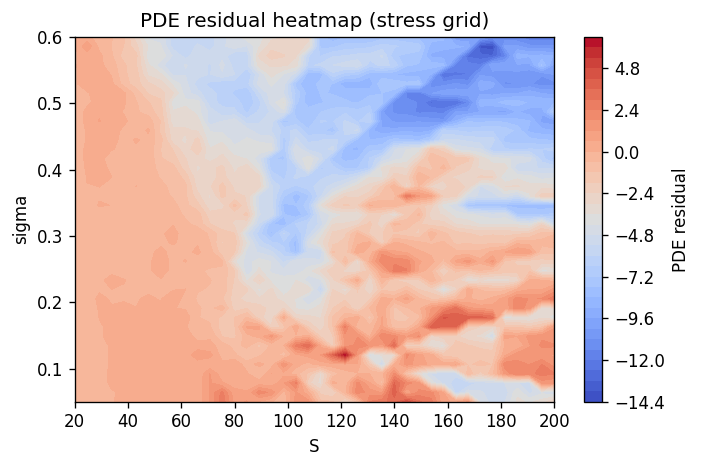

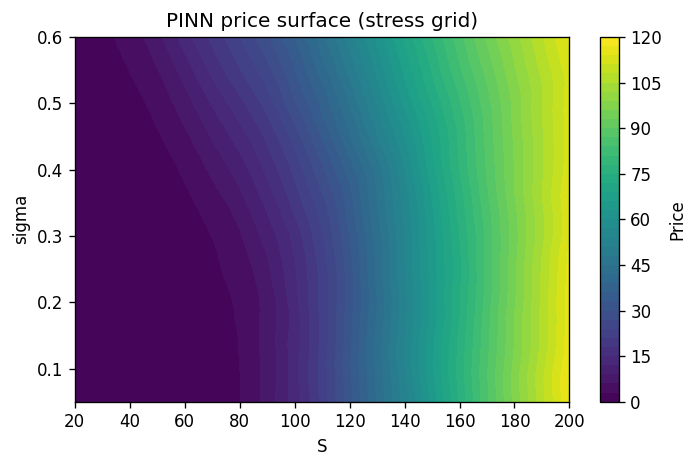

In [16]:

# 7) PDE residual + surface diagnostics
if not TORCH_OK or model is None:
    residual_stats = None
    print('Skipping PDE residual diagnostics (model unavailable).')
else:
    from src.losses import compute_pde_residual
    from src.preprocessing import normalize_inputs

    device = next(model.parameters()).device
    G = CONFIG['residual_grid']
    S_grid = torch.linspace(20, 200, G, device=device)
    sigma_grid = torch.linspace(0.05, 0.6, G, device=device)
    S_mesh, sigma_mesh = torch.meshgrid(S_grid, sigma_grid, indexing='ij')
    t_mesh = torch.full_like(S_mesh, snapshot_t)

    resid = compute_pde_residual(
        model,
        S_mesh.flatten().requires_grad_(True),
        t_mesh.flatten().requires_grad_(True),
        sigma_mesh.flatten(),
        r=r,
    )
    resid_np = resid.detach().cpu().numpy().reshape(G, G)

    residual_stats = {
        'mean': float(resid_np.mean()),
        'std': float(resid_np.std()),
        'max_abs': float(np.max(np.abs(resid_np))),
    }
    print(json.dumps(residual_stats, indent=2))

    plt.figure(figsize=(6,4))
    plt.contourf(S_grid.cpu().numpy(), sigma_grid.cpu().numpy(), resid_np.T, levels=40, cmap='coolwarm')
    plt.colorbar(label='PDE residual')
    plt.xlabel('S')
    plt.ylabel('sigma')
    plt.title('PDE residual heatmap (stress grid)')
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'stress_test' / 'pde_residual_heatmap.png', dpi=200)

    with torch.no_grad():
        features = normalize_inputs(
            S_mesh.flatten(),
            t_mesh.flatten(),
            sigma_mesh.flatten(),
        )
        surface = model(features).detach().cpu().numpy().reshape(G, G)
    plt.figure(figsize=(6,4))
    plt.contourf(S_grid.cpu().numpy(), sigma_grid.cpu().numpy(), surface.T, levels=40, cmap='viridis')
    plt.colorbar(label='Price')
    plt.xlabel('S')
    plt.ylabel('sigma')
    plt.title('PINN price surface (stress grid)')
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'stress_test' / 'surface_grid.png', dpi=200)


In [17]:

# 8) Consolidated summary + optional JSON export
summary_payload = {
    'timestamp': datetime.utcnow().isoformat() + 'Z',
    'config': CONFIG,
    'evaluation': evaluation_summary,
    'residual': residual_stats,
    'fd_delta_mae': float(fd_delta_mae),
    'fd_gamma_mae': float(fd_gamma_mae),
    'mc_delta_mean_abs_error': float(mc_df['abs_err'].mean()) if 'mc_df' in globals() else None,
}

print(json.dumps(summary_payload, indent=2))

summary_path = RESULTS_DIR / 'stress_test_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary_payload, f, indent=2)
print(f"Wrote summary to {summary_path}")


{
  "timestamp": "2025-10-13T23:31:19.886474Z",
  "config": {
    "train_epochs": 50,
    "batch_size": 4096,
    "learning_rate": 0.001,
    "use_warmup": true,
    "warmup_steps": 500,
    "grad_clip": 1.0,
    "adaptive_sampling": true,
    "adaptive_every": 5,
    "adaptive_points": 20000,
    "adaptive_radius": 0.1,
    "adaptive_eval_samples": 50000,
    "baseline_samples": 1000,
    "mc_paths": 20000,
    "mc_eval_points": 25,
    "num_val_samples": 5000,
    "residual_grid": 40,
    "load_existing_checkpoint": false,
    "save_checkpoint": false,
    "checkpoint_name": "pinn_checkpoint.pt",
    "device": "cpu"
  },
  "evaluation": {
    "N_eval": 200,
    "price_mae": 6.398726087571362,
    "price_rmse": 8.788776390998382,
    "delta_mae": 0.09040983838824002,
    "gamma_mae": 0.010774306024810077
  },
  "residual": {
    "mean": -2.8435797691345215,
    "std": 3.4899086952209473,
    "max_abs": 14.194435119628906
  },
  "fd_delta_mae": 4.037401992084984e-09,
  "fd_gamma_mae": 